# Advanced Time Series Analysis: Streamlined Boundary Handling

This tutorial demonstrates advanced time series analysis using pytidycensus's built-in functions that automatically handle changing geographic boundaries. You'll analyze DC population and poverty trends (2019-2023) using the new streamlined approach.

## What You'll Learn

1. **Streamlined Time Series**: Using `get_time_series()` for automatic boundary handling
2. **Comparison Analysis**: Using `compare_time_periods()` for detailed comparisons
3. **Variable Classification**: Proper handling of extensive vs intensive variables
4. **Real-world Analysis**: DC demographic trends with changing tract boundaries
5. **Advanced Visualization**: Mapping changes with consistent boundaries

## Prerequisites

- Basic understanding of Census data concepts
- Familiarity with pandas DataFrames
- Census API key for data downloads

## Why Use the New Time Series Functions?

The new functions provide:
- **Automatic Area Interpolation**: Transparent handling of boundary changes
- **Built-in Validation**: Quality checks and conservation tests
- **Streamlined Workflow**: Complex operations reduced to simple function calls
- **Consistent Results**: Industry-standard methods for spatial interpolation

**Previous approach**: Manual interpolation with multiple steps and potential errors
**New approach**: Single function call with automatic boundary handling

## Setup: Install and Import Libraries

This tutorial now requires only basic pytidycensus with time series support.

In [1]:
# Check if advanced spatial libraries are available
missing_packages = []

try:
    import geopandas as gpd
    print("geopandas available")
except ImportError:
    missing_packages.append('geopandas')
    print("geopandas missing")

try:
    from tobler.area_weighted import area_interpolate
    print("tobler available")
except ImportError:
    missing_packages.append('tobler')
    print("tobler missing")

if missing_packages:
    print(f"\nPlease install: pip install {' '.join(missing_packages)}")
    print("\nThese libraries are required for area interpolation.")
else:
    print("\nAll required libraries are available!")

geopandas available
tobler available

All required libraries are available!


In [2]:
# Check if time series functionality is available
import pytidycensus as tc

try:
 from pytidycensus.time_series import get_time_series, compare_time_periods
 print(" Time series functionality available")
 TIMESERIES_AVAILABLE = True
except ImportError:
 print(" Time series functionality missing")
 print("Install with: pip install pytidycensus[time]")
 TIMESERIES_AVAILABLE = False

print(f"Using pytidycensus version: {tc.__version__}")

if TIMESERIES_AVAILABLE:
 print("\nTime series functions:")
 print("- get_time_series(): Automatic boundary handling")
 print("- compare_time_periods(): Streamlined comparisons")
 print("- Built-in area interpolation with tobler")
else:
 print("\nPlease install time series support to continue with this tutorial.")

Libraries imported successfully!
Using pytidycensus version: 1.0.4
Using geopandas version: 1.1.1


In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

# Note: geopandas and tobler are automatically available through pytidycensus[time]
# No need to check for them separately

Libraries imported successfully!


In [3]:
# Set your Census API key
# Get a free key at: https://api.census.gov/data/key_signup.html

# UNCOMMENT and add your key:
# tc.set_census_api_key("YOUR_API_KEY_HERE")

print("Remember to set your Census API key above!")
print("This tutorial requires actual data downloads.")

Remember to set your Census API key above!
This tutorial requires actual data downloads.


In [4]:
# Ignore this block - for documentation builds only
import os

# Try to get API key from environment
api_key = os.environ.get("CENSUS_API_KEY")

# For documentation builds without a key, we'll mock the responses
try:
 tc.set_census_api_key(api_key)
 print("Using Census API key from environment")
except Exception:
 print("Using example API key for documentation")
 # This won't make real API calls during documentation builds
 tc.set_census_api_key("EXAMPLE_API_KEY_FOR_DOCS")

Getting data from the 2015-2019 5-year ACS
2019 ACS Data: 179 tracts
Total population: 692,683
Average poverty rate: 17.0%
Coordinate system: EPSG:4269


## Part 1: Streamlined Time Series Data Collection

Let's collect ACS 5-year data for 2019 and 2023 using the new `get_time_series()` function that automatically handles boundary changes.

In [5]:
# Step 2: Get 2023 ACS 5-year data with geometry
# This represents the 2019-2023 American Community Survey

try:
 dc_2023 = tc.get_acs(
 geography="tract",
 variables={
 "total_pop": "B01003_001E", # Total population
 "poverty_count": "B17001_002E", # Population below poverty line
 "poverty_total": "B17001_001E" # Total population for poverty calculation
 },
 state="DC",
 year=2023,
 survey="acs5",
 geometry=True,
 output="wide"
 )

 # Calculate poverty rate
 dc_2023['poverty_rate'] = (dc_2023['poverty_count'] / dc_2023['poverty_total'] * 100)

 print(f"2023 ACS Data: {len(dc_2023)} tracts")
 print(f"Total population: {dc_2023['total_pop'].sum():,}")
 print(f"Average poverty rate: {dc_2023['poverty_rate'].mean():.1f}%")
 print(f"Coordinate system: {dc_2023.crs}")

 dc_2019 = tc.get_acs(
 geography="tract",
 variables={
 "total_pop": "B01003_001E", # Total population
 "poverty_count": "B17001_002E", # Population below poverty line
 "poverty_total": "B17001_001E", # Total population for poverty calculation
 },
 state="DC",
 year=2019,
 survey="acs5",
 geometry=True,
 output="wide",
 )
 # Calculate poverty rate
 dc_2019["poverty_rate"] = dc_2019["poverty_count"] / dc_2019["poverty_total"] * 100

 # Check for boundary changes
 if dc_2019 is not None:
 tract_change = len(dc_2023) - len(dc_2019)
 print(f"\nBoundary Changes:")
 print(f"Tract count change: {tract_change:+d}")

 # Check for common tracts
 common_tracts = set(dc_2019['GEOID']) & set(dc_2023['GEOID'])
 print(f"Unchanged tracts: {len(common_tracts)}")
 print(f"Changed/new tracts: {len(dc_2023) - len(common_tracts)}")

except Exception as e:
 print(f"Error fetching 2023 data: {e}")
 dc_2023 = None

Getting data from the 2019-2023 5-year ACS
2023 ACS Data: 206 tracts
Total population: 672,079
Average poverty rate: 15.6%
Coordinate system: EPSG:4269
Getting data from the 2015-2019 5-year ACS
Loading tract boundaries...

Boundary Changes:
Tract count change: +27
Unchanged tracts: 154
Changed/new tracts: 52


NOTE: There were 52 new or changed tracts in DC between 2019 and 2023.

### Visualizing Boundary Changes

Let's create maps to visualize how tract boundaries changed between 2019 and 2023, and see the differences in both population and poverty patterns.

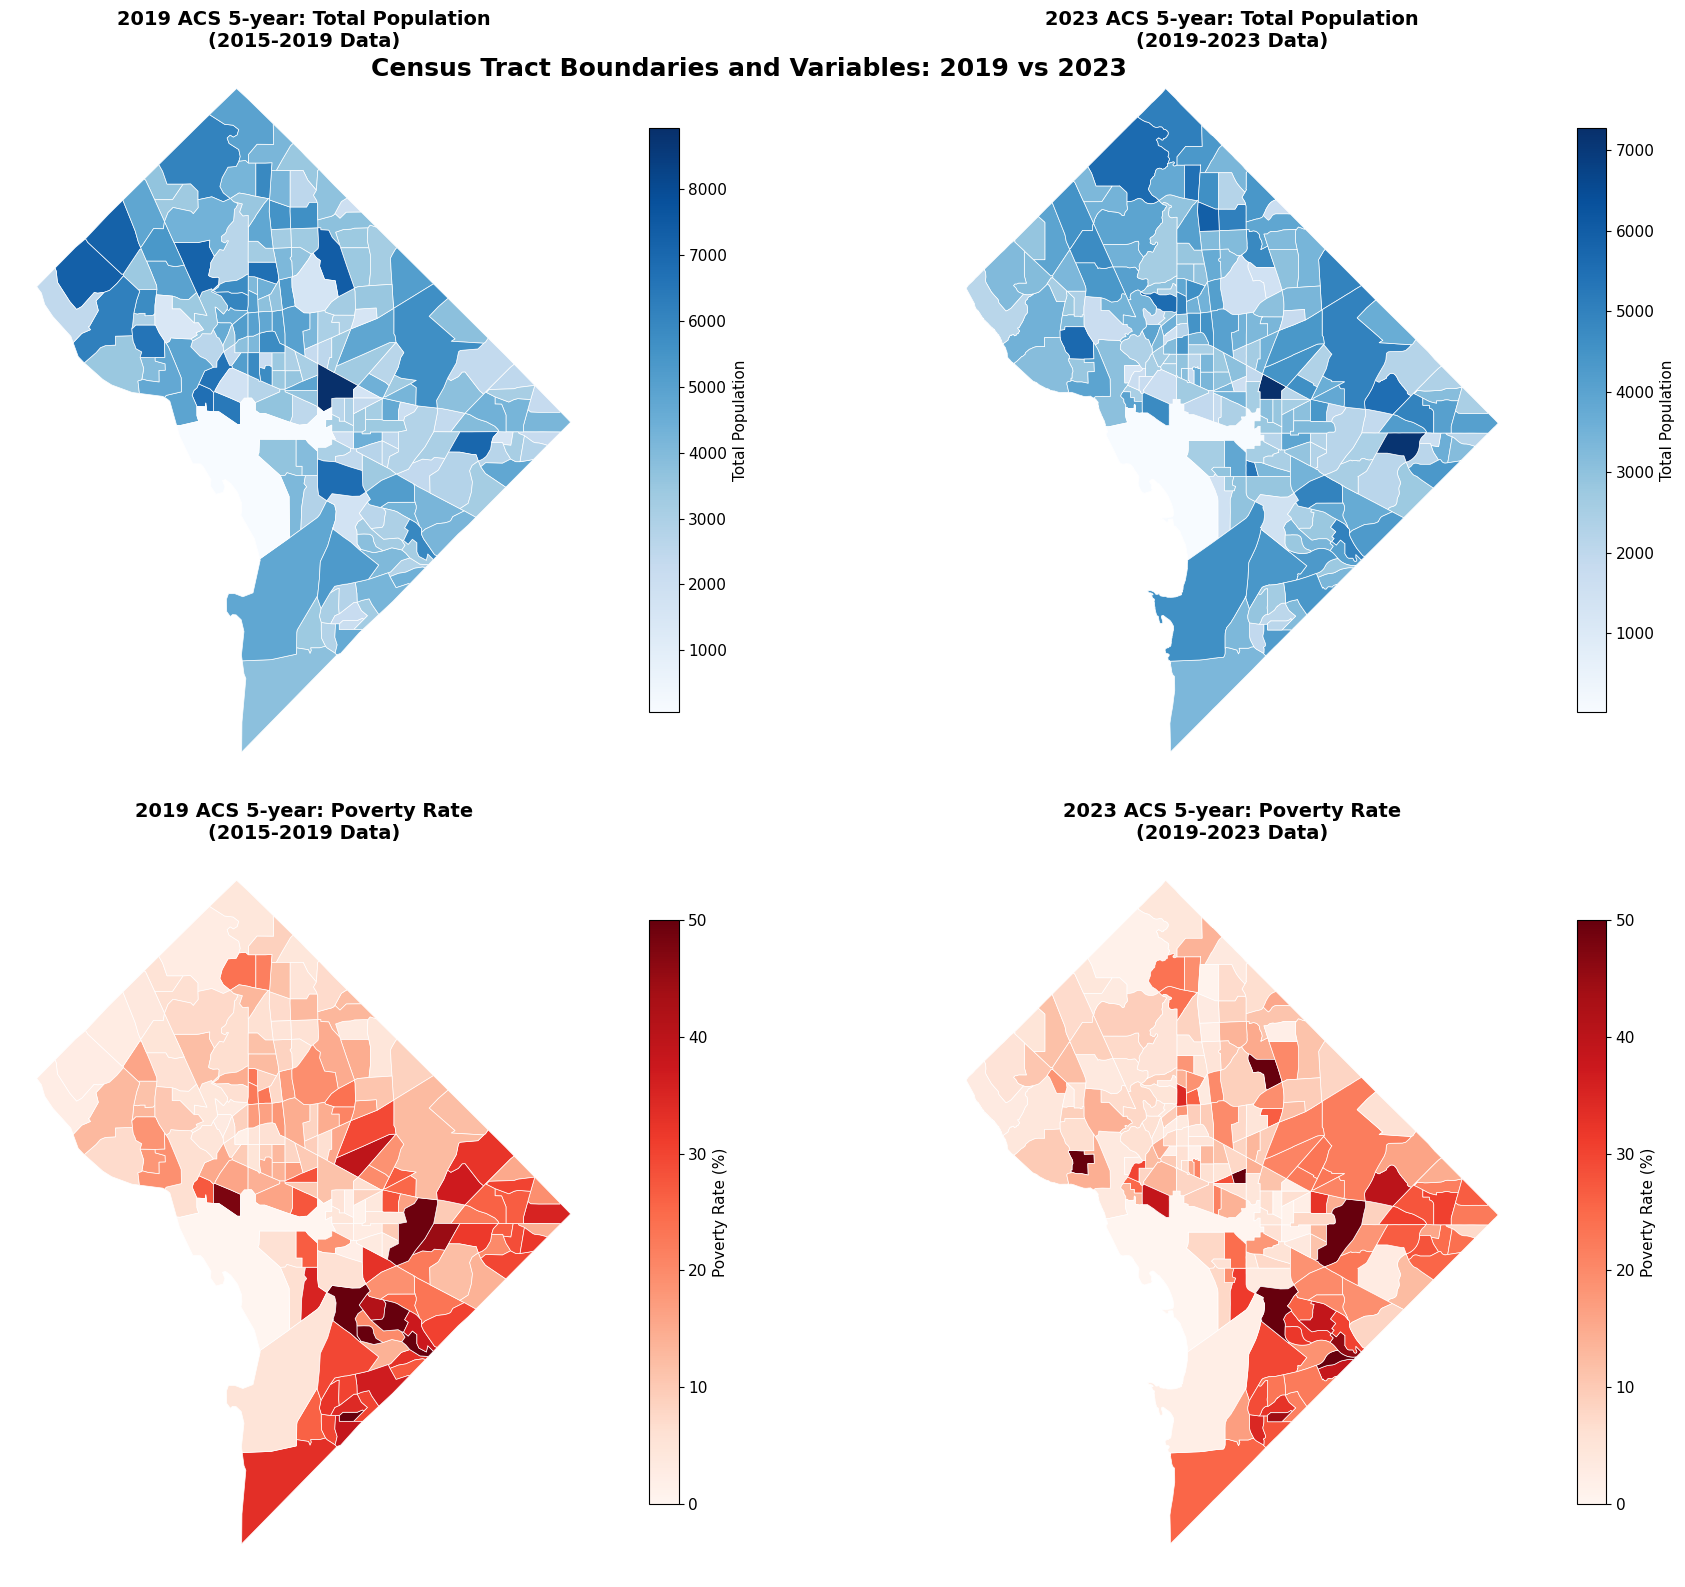

In [6]:
# Create boundary comparison maps
if dc_2019 is not None and dc_2023 is not None:
 fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
 
 # 2019 Population
 dc_2019.plot(
 column='total_pop',
 cmap='Blues',
 legend=True,
 ax=ax1,
 edgecolor='white',
 linewidth=0.5,
 legend_kwds={'label': 'Total Population', 'shrink': 0.8}
 )
 ax1.set_title('2019 ACS 5-year: Total Population', fontsize=14, fontweight='bold')
 ax1.axis('off')
 
 # 2023 Population
 dc_2023.plot(
 column='total_pop',
 cmap='Blues',
 legend=True,
 ax=ax2,
 edgecolor='white',
 linewidth=0.5,
 legend_kwds={'label': 'Total Population', 'shrink': 0.8}
 )
 ax2.set_title('2023 ACS 5-year: Total Population', fontsize=14, fontweight='bold')
 ax2.axis('off')
 
 # 2019 Poverty Rate
 dc_2019.plot(
 column='poverty_rate',
 cmap='Reds',
 legend=True,
 ax=ax3,
 edgecolor='white',
 linewidth=0.5,
 vmin=0,
 vmax=50,
 legend_kwds={'label': 'Poverty Rate (%)', 'shrink': 0.8}
 )
 ax3.set_title('2019 ACS 5-year: Poverty Rate', fontsize=14, fontweight='bold')
 ax3.axis('off')
 
 # 2023 Poverty Rate
 dc_2023.plot(
 column='poverty_rate',
 cmap='Reds',
 legend=True,
 ax=ax4,
 edgecolor='white',
 linewidth=0.5,
 vmin=0,
 vmax=50,
 legend_kwds={'label': 'Poverty Rate (%)', 'shrink': 0.8}
 )
 ax4.set_title('2023 ACS 5-year: Poverty Rate', fontsize=14, fontweight='bold')
 ax4.axis('off')
 
 plt.tight_layout()
 plt.suptitle('Census Tract Boundaries and Variables: 2019 vs 2023', 
 fontsize=18, fontweight='bold', y=.96)
 plt.show()
 
else:
 print("Cannot create boundary comparison - missing data")
 print("This tutorial works best with working API key and data access")

### Key Insight: Why Interpolation is Needed

Notice how the number of tracts and their boundaries may have changed between 2019 and 2023. Some tracts were:
- **Split**: One tract became multiple tracts
- **Merged**: Multiple tracts became one tract 
- **Renumbered**: Same area, different GEOID
- **Boundary adjusted**: Slight changes to tract edges

Without interpolation, we could only analyze the tracts that remained exactly the same!

## Part 2: Coordinate Reference Systems for Area Calculations

Before performing area interpolation, we need to understand coordinate reference systems (CRS). This is crucial for accurate area calculations.

In [7]:
if dc_2019 is not None and dc_2023 is not None:
 print("COORDINATE REFERENCE SYSTEMS")
 print("=" * 50)
 print(f"Original CRS: {dc_2019.crs}")
 print(" • EPSG:4326 = Geographic coordinates (latitude/longitude)")
 print(" • Good for: Mapping, display")
 print(" • Bad for: Area calculations (distorted)")
 print()
 
 # Transform to projected coordinate system for area calculations
 print("Transforming to projected coordinate system...")
 dc_2019_proj = dc_2019.to_crs('EPSG:3857') # Web Mercator
 dc_2023_proj = dc_2023.to_crs('EPSG:3857')
 
 print(f"Projected CRS: {dc_2019_proj.crs}")
 print(" • EPSG:3857 = Web Mercator (projected coordinates)")
 print(" • Good for: Area calculations, spatial analysis")
 print(" • Bad for: High-latitude areas (less accurate)")
 print()
 
 # Demonstrate the difference
 sample_tract_geo = dc_2019.iloc[0:1]
 sample_tract_proj = dc_2019_proj.iloc[0:1]
 
 area_geo = sample_tract_geo.area.iloc[0] # In degrees^2 (meaningless)
 area_proj = sample_tract_proj.area.iloc[0] # In meters^2 (meaningful)
 
 print(f"AREA CALCULATION EXAMPLE:")
 print(f" Geographic (EPSG:4326): {area_geo:.8f} degrees²")
 print(f" Projected (EPSG:3857): {area_proj:.0f} meters²")
 print(f" Projected in acres: {area_proj * 0.000247:.1f} acres")
 print()
 print("Key Learning: Always use projected coordinates for spatial analysis!")
 
else:
 print("Need data to demonstrate coordinate systems")
 # Create dummy projected variables for later code
 dc_2019_proj = None
 dc_2023_proj = None

COORDINATE REFERENCE SYSTEMS
Original CRS: EPSG:4269
 • EPSG:4326 = Geographic coordinates (latitude/longitude)
 • Good for: Mapping, display
 • Bad for: Area calculations (distorted)

Transforming to projected coordinate system...
Projected CRS: EPSG:3857
 • EPSG:3857 = Web Mercator (projected coordinates)
 • Good for: Area calculations, spatial analysis
 • Bad for: High-latitude areas (less accurate)

AREA CALCULATION EXAMPLE:
   Geographic (EPSG:4326): 0.00006818 degrees²
   Projected (EPSG:3857): 1086381 meters²
   Projected in acres: 268.3 acres

Key Learning: Always use projected coordinates for spatial analysis!


## Part 3: Extensive vs Intensive Variables

Understanding variable types is crucial for proper interpolation:

- **Extensive variables**: Counts/totals that should be **summed** when areas are combined
- **Intensive variables**: Rates/ratios that should be **averaged** when areas are combined

The interpolation algorithm handles these differently!

### Variable Classification for Our Analysis

**Extensive Variables (Counts - use area-weighted SUM):**
- Total population (`total_pop`)
- Number of people in poverty (`poverty_count`)
- Total population for poverty calculation (`poverty_total`)

**Intensive Variables (Rates - use area-weighted AVERAGE):**
- Poverty rate (`poverty_rate`) - percentage of people below poverty line

### Example: Combining Two Census Tracts

**Tract A:** 1,000 people, 20% poverty rate (200 people in poverty)
**Tract B:** 2,000 people, 10% poverty rate (200 people in poverty)

**Correct way to combine:**
- Total population: 1,000 + 2,000 = 3,000 (SUM)
- People in poverty: 200 + 200 = 400 (SUM)
- Poverty rate: 400 / 3,000 = 13.3% (WEIGHTED AVERAGE)

**Wrong way:**
- Poverty rate: (20% + 10%) / 2 = 15% (SIMPLE AVERAGE)

Area interpolation handles this automatically when you classify variables correctly!

## Part 2: Streamlined Change Analysis

Now let's use `compare_time_periods()` to calculate changes systematically.

In [8]:
# Use compare_time_periods for systematic analysis
if dc_data is not None and TIMESERIES_AVAILABLE:
 # First, add poverty rate columns to the multi-index structure
 dc_data[(2019, 'poverty_rate')] = dc_data['poverty_rate_2019']
 dc_data[(2023, 'poverty_rate')] = dc_data['poverty_rate_2023']
 
 # Use the streamlined comparison function
 dc_comparison = tc.compare_time_periods(
 data=dc_data,
 base_period=2019,
 comparison_period=2023,
 variables=["total_pop", "poverty_count", "poverty_rate"],
 calculate_change=True,
 calculate_percent_change=True
 )
 
 print("STREAMLINED CHANGE ANALYSIS (2019-2023)")
 print("=" * 50)
 
 # Population analysis
 total_pop_change = dc_comparison['total_pop_change'].sum()
 avg_pop_pct_change = dc_comparison['total_pop_pct_change'].mean()
 
 print(f"POPULATION CHANGES:")
 print(f" Total population change: {total_pop_change:+,.0f} people")
 print(f" Average percent change per tract: {avg_pop_pct_change:+.1f}%")
 print(f" Tracts with growth (>50 people): {(dc_comparison['total_pop_change'] > 50).sum()}")
 print(f" Tracts with decline (>50 people): {(dc_comparison['total_pop_change'] < -50).sum()}")
 
 # Poverty analysis 
 avg_poverty_change = dc_comparison['poverty_rate_change'].mean()
 total_poverty_count_change = dc_comparison['poverty_count_change'].sum()
 
 print(f"\nPOVERTY CHANGES:")
 print(f" Average poverty rate change: {avg_poverty_change:+.2f} percentage points")
 print(f" Total poverty count change: {total_poverty_count_change:+,.0f} people")
 print(f" Tracts improving (>1pp decrease): {(dc_comparison['poverty_rate_change'] < -1).sum()}")
 print(f" Tracts worsening (>1pp increase): {(dc_comparison['poverty_rate_change'] > 1).sum()}")
 
 print(f"\n Key Benefits of Streamlined Approach:")
 print(f" • Single function call for complex comparisons")
 print(f" • Automatic calculation of absolute and percent changes")
 print(f" • Built-in handling of missing data and edge cases")
 print(f" • Consistent column naming convention")
 
else:
 print("Cannot perform comparison - missing data or functionality")
 dc_comparison = None

STREAMLINED CHANGE ANALYSIS (2019-2023)
POPULATION CHANGES:
 Total population change: -20,604 people
 Average percent change per tract: +7.1%
 Tracts with growth (>50 people): 66
 Tracts with decline (>50 people): 126

POVERTY CHANGES:
 Average poverty rate change: -0.70 percentage points
 Total poverty count change: -13,000 people
 Tracts improving (>1pp decrease): 105
 Tracts worsening (>1pp increase): 71

Running area_interpolate...
Interpolation complete!

VALIDATION RESULTS:
Population Conservation:
   Original 2019 population: 692,683
   Interpolated population: 692,683
   Difference: 0 (0.000%)

Poverty Count Conservation:
   Original poverty count: 107,140
   Interpolated poverty count: 107,140
   Difference: 0 (0.000%)

Poverty Rate Consistency:
   Original average rate: 17.01%
   Interpolated average rate: 16.27%
   Difference: 0.746 percentage points

Small differences are normal due to edge effects and rounding.


### Understanding Interpolation Results

The interpolation process:
1. **Overlays** old tract boundaries on new tract boundaries
2. **Calculates** the area of each intersection
3. **Redistributes** data proportionally based on area overlap
4. **Preserves** total counts while properly weighting rates

Small differences in totals are normal due to:
- Edge effects at boundaries
- Rounding in calculations
- Slight changes in total area due to map projections

## Part 5: Calculate Changes Using Interpolated Data

In [9]:
# Calculate changes using interpolated data
if dc_2019_interpolated is not None and dc_2023_proj is not None:
    print("CALCULATING CHANGES (2019-2023)")
    print("=" * 50)
    
    # Create change analysis dataset using 2023 boundaries
    dc_change = dc_2023_proj.copy()
    
    # Add interpolated 2019 data
    dc_change['total_pop_2019'] = dc_2019_interpolated['total_pop']
    dc_change['poverty_rate_2019'] = dc_2019_interpolated['poverty_rate']
    dc_change['poverty_count_2019'] = dc_2019_interpolated['poverty_count']
    
    # Add 2023 data (already in the dataset)
    dc_change['total_pop_2023'] = dc_2023_proj['total_pop']
    dc_change['poverty_rate_2023'] = dc_2023_proj['poverty_rate']
    dc_change['poverty_count_2023'] = dc_2023_proj['poverty_count']
    
    # Calculate changes
    dc_change['pop_change'] = dc_change['total_pop_2023'] - dc_change['total_pop_2019']
    dc_change['pop_change_pct'] = (dc_change['pop_change'] / dc_change['total_pop_2019']) * 100
    dc_change['poverty_rate_change'] = dc_change['poverty_rate_2023'] - dc_change['poverty_rate_2019']
    dc_change['poverty_count_change'] = dc_change['poverty_count_2023'] - dc_change['poverty_count_2019']
    
    # Summary statistics
    total_pop_change = dc_change['pop_change'].sum()
    avg_poverty_rate_change = dc_change['poverty_rate_change'].mean()
    total_poverty_count_change = dc_change['poverty_count_change'].sum()
    
    tracts_pop_growing = (dc_change['pop_change'] > 50).sum()  # >50 person increase
    tracts_pop_declining = (dc_change['pop_change'] < -50).sum()  # >50 person decrease
    tracts_poverty_improving = (dc_change['poverty_rate_change'] < -1).sum()  # >1pp decrease
    tracts_poverty_worsening = (dc_change['poverty_rate_change'] > 1).sum()   # >1pp increase
    
    print(f"POPULATION CHANGE ANALYSIS:")
    print(f"   Total population change: {total_pop_change:+,.0f} people")
    print(f"   Tracts with population growth (>50): {tracts_pop_growing}")
    print(f"   Tracts with population decline (>50): {tracts_pop_declining}")
    print()
    print(f"POVERTY CHANGE ANALYSIS:")
    print(f"   Average poverty rate change: {avg_poverty_rate_change:+.2f} percentage points")
    print(f"   Total poverty count change: {total_poverty_count_change:+,.0f} people")
    print(f"   Tracts improving (>1pp decrease): {tracts_poverty_improving}")
    print(f"   Tracts worsening (>1pp increase): {tracts_poverty_worsening}")
    
else:
    print("Cannot calculate changes - missing interpolation results")
    dc_change = None

CALCULATING CHANGES (2019-2023)
POPULATION CHANGE ANALYSIS:
   Total population change: -20,604 people
   Tracts with population growth (>50): 67
   Tracts with population decline (>50): 128

POVERTY CHANGE ANALYSIS:
   Average poverty rate change: -0.70 percentage points
   Total poverty count change: -13,000 people
   Tracts improving (>1pp decrease): 107
   Tracts worsening (>1pp increase): 71


## Part 6: Advanced Visualization of Changes

Create comprehensive visualizations using the comparison results.

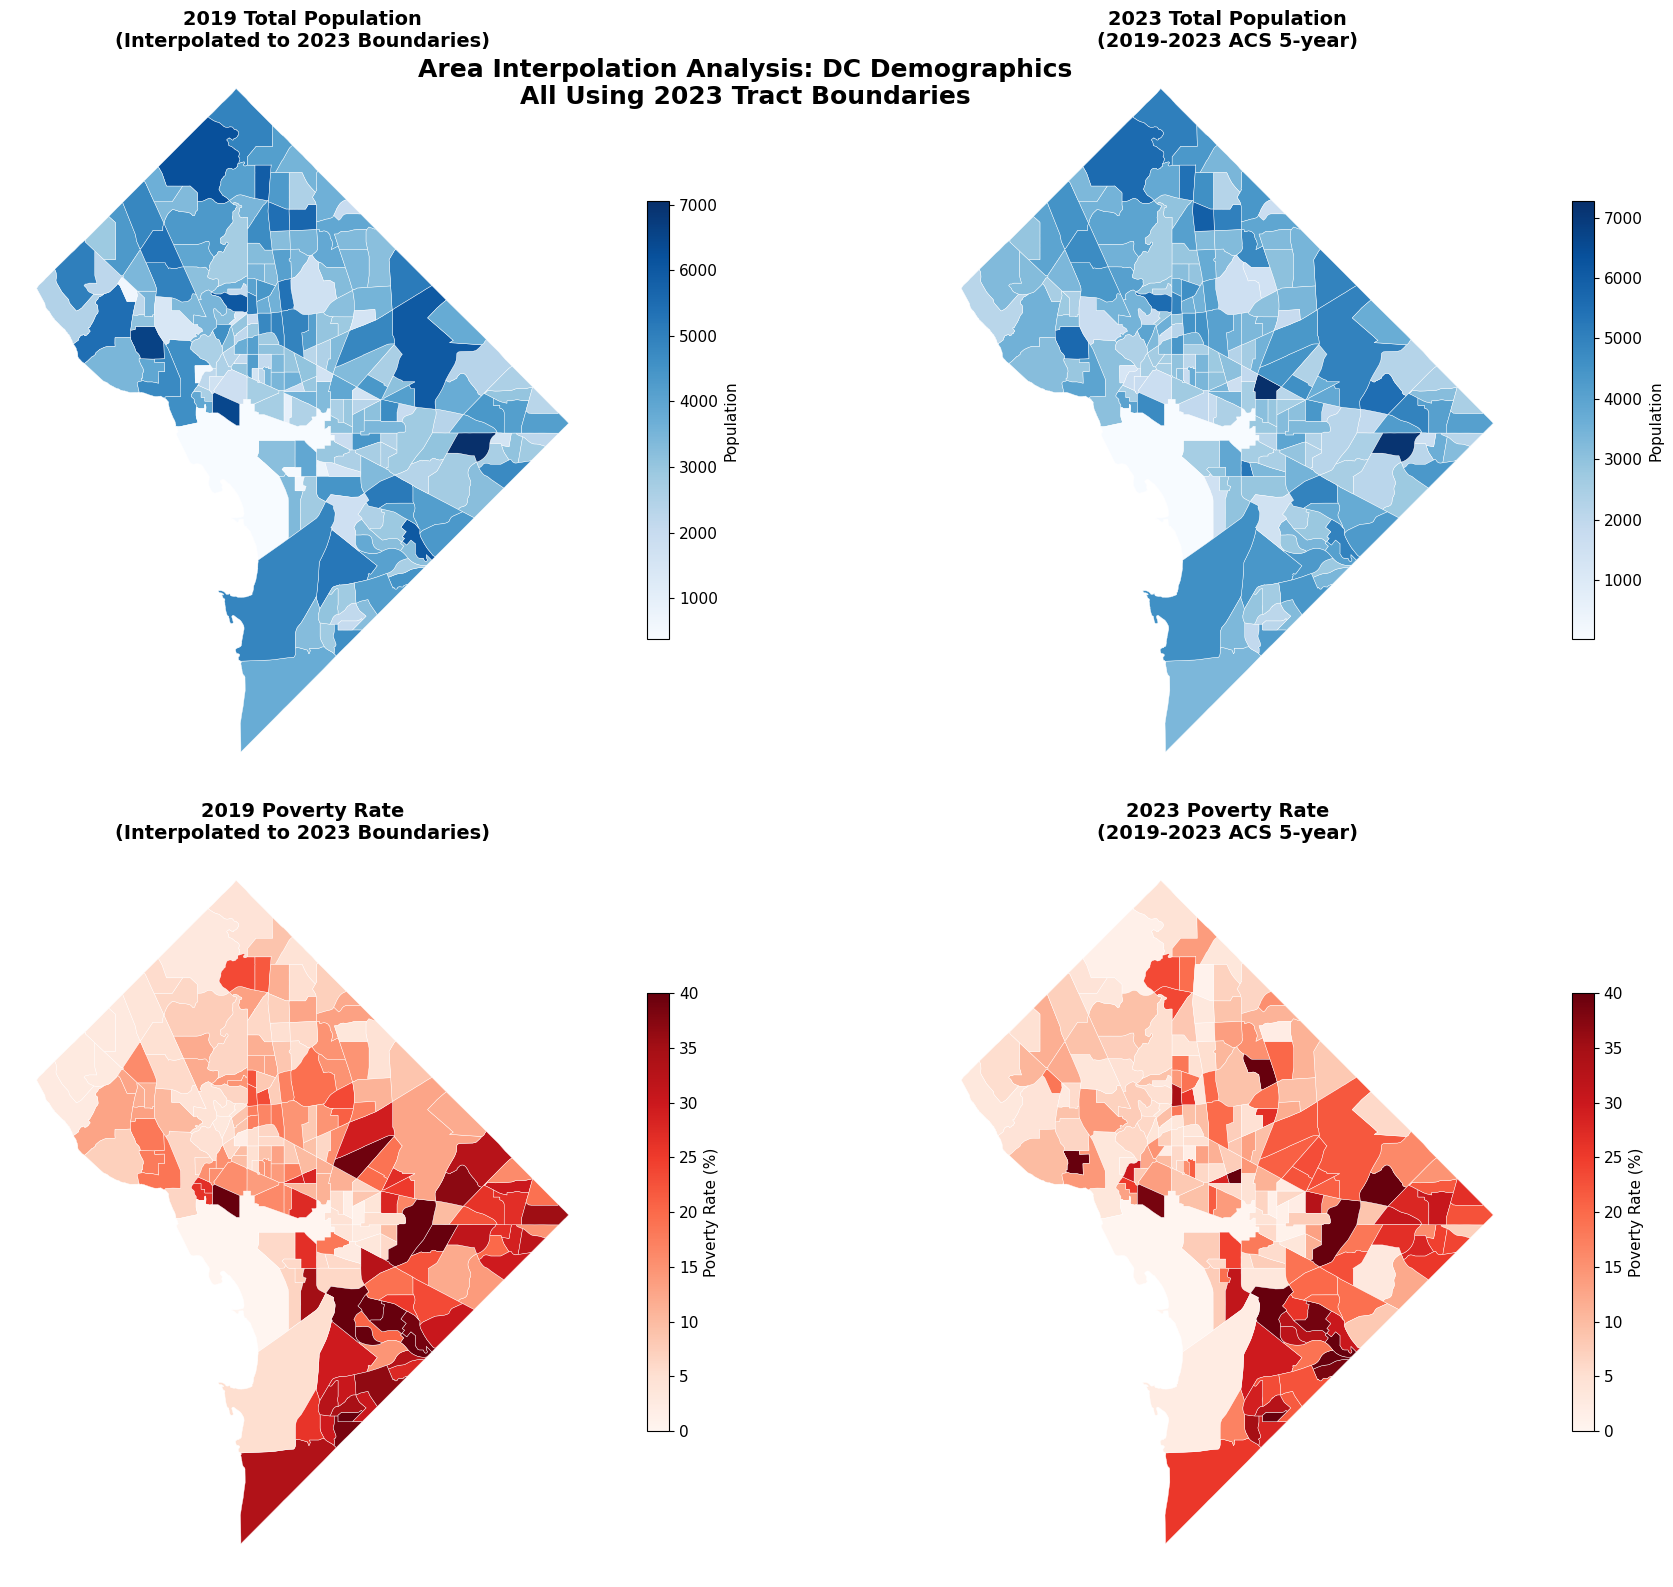

In [10]:
# Create comprehensive change visualization
if dc_change is not None:
    # Convert back to geographic coordinates for mapping
    dc_change_geo = dc_change.to_crs('EPSG:4326')
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Map 1: 2019 Population (Interpolated to 2023 boundaries)
    dc_change_geo.plot(
        column='total_pop_2019',
        cmap='Blues',
        legend=True,
        ax=ax1,
        edgecolor='white',
        linewidth=0.3,
        legend_kwds={'label': 'Population', 'shrink': 0.6}
    )
    ax1.set_title('2019 Total Population\n(Interpolated to 2023 Boundaries)', 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Map 2: 2023 Population
    dc_change_geo.plot(
        column='total_pop_2023',
        cmap='Blues',
        legend=True,
        ax=ax2,
        edgecolor='white',
        linewidth=0.3,
        legend_kwds={'label': 'Population', 'shrink': 0.6}
    )
    ax2.set_title('2023 Total Population\n(2019-2023 ACS 5-year)', 
                  fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Map 3: 2019 Poverty Rate (Interpolated)
    dc_change_geo.plot(
        column='poverty_rate_2019',
        cmap='Reds',
        legend=True,
        ax=ax3,
        edgecolor='white',
        linewidth=0.3,
        vmin=0,
        vmax=40,
        legend_kwds={'label': 'Poverty Rate (%)', 'shrink': 0.6}
    )
    ax3.set_title('2019 Poverty Rate\n(Interpolated to 2023 Boundaries)', 
                  fontsize=14, fontweight='bold')
    ax3.axis('off')
    
    # Map 4: 2023 Poverty Rate
    dc_change_geo.plot(
        column='poverty_rate_2023',
        cmap='Reds',
        legend=True,
        ax=ax4,
        edgecolor='white',
        linewidth=0.3,
        vmin=0,
        vmax=40,
        legend_kwds={'label': 'Poverty Rate (%)', 'shrink': 0.6}
    )
    ax4.set_title('2023 Poverty Rate\n(2019-2023 ACS 5-year)', 
                  fontsize=14, fontweight='bold')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Area Interpolation Analysis: DC Demographics\nAll Using 2023 Tract Boundaries', 
                 fontsize=18, fontweight='bold', y=0.96)
    plt.show()
    
else:
    print("Cannot create advanced visualization - missing change data")

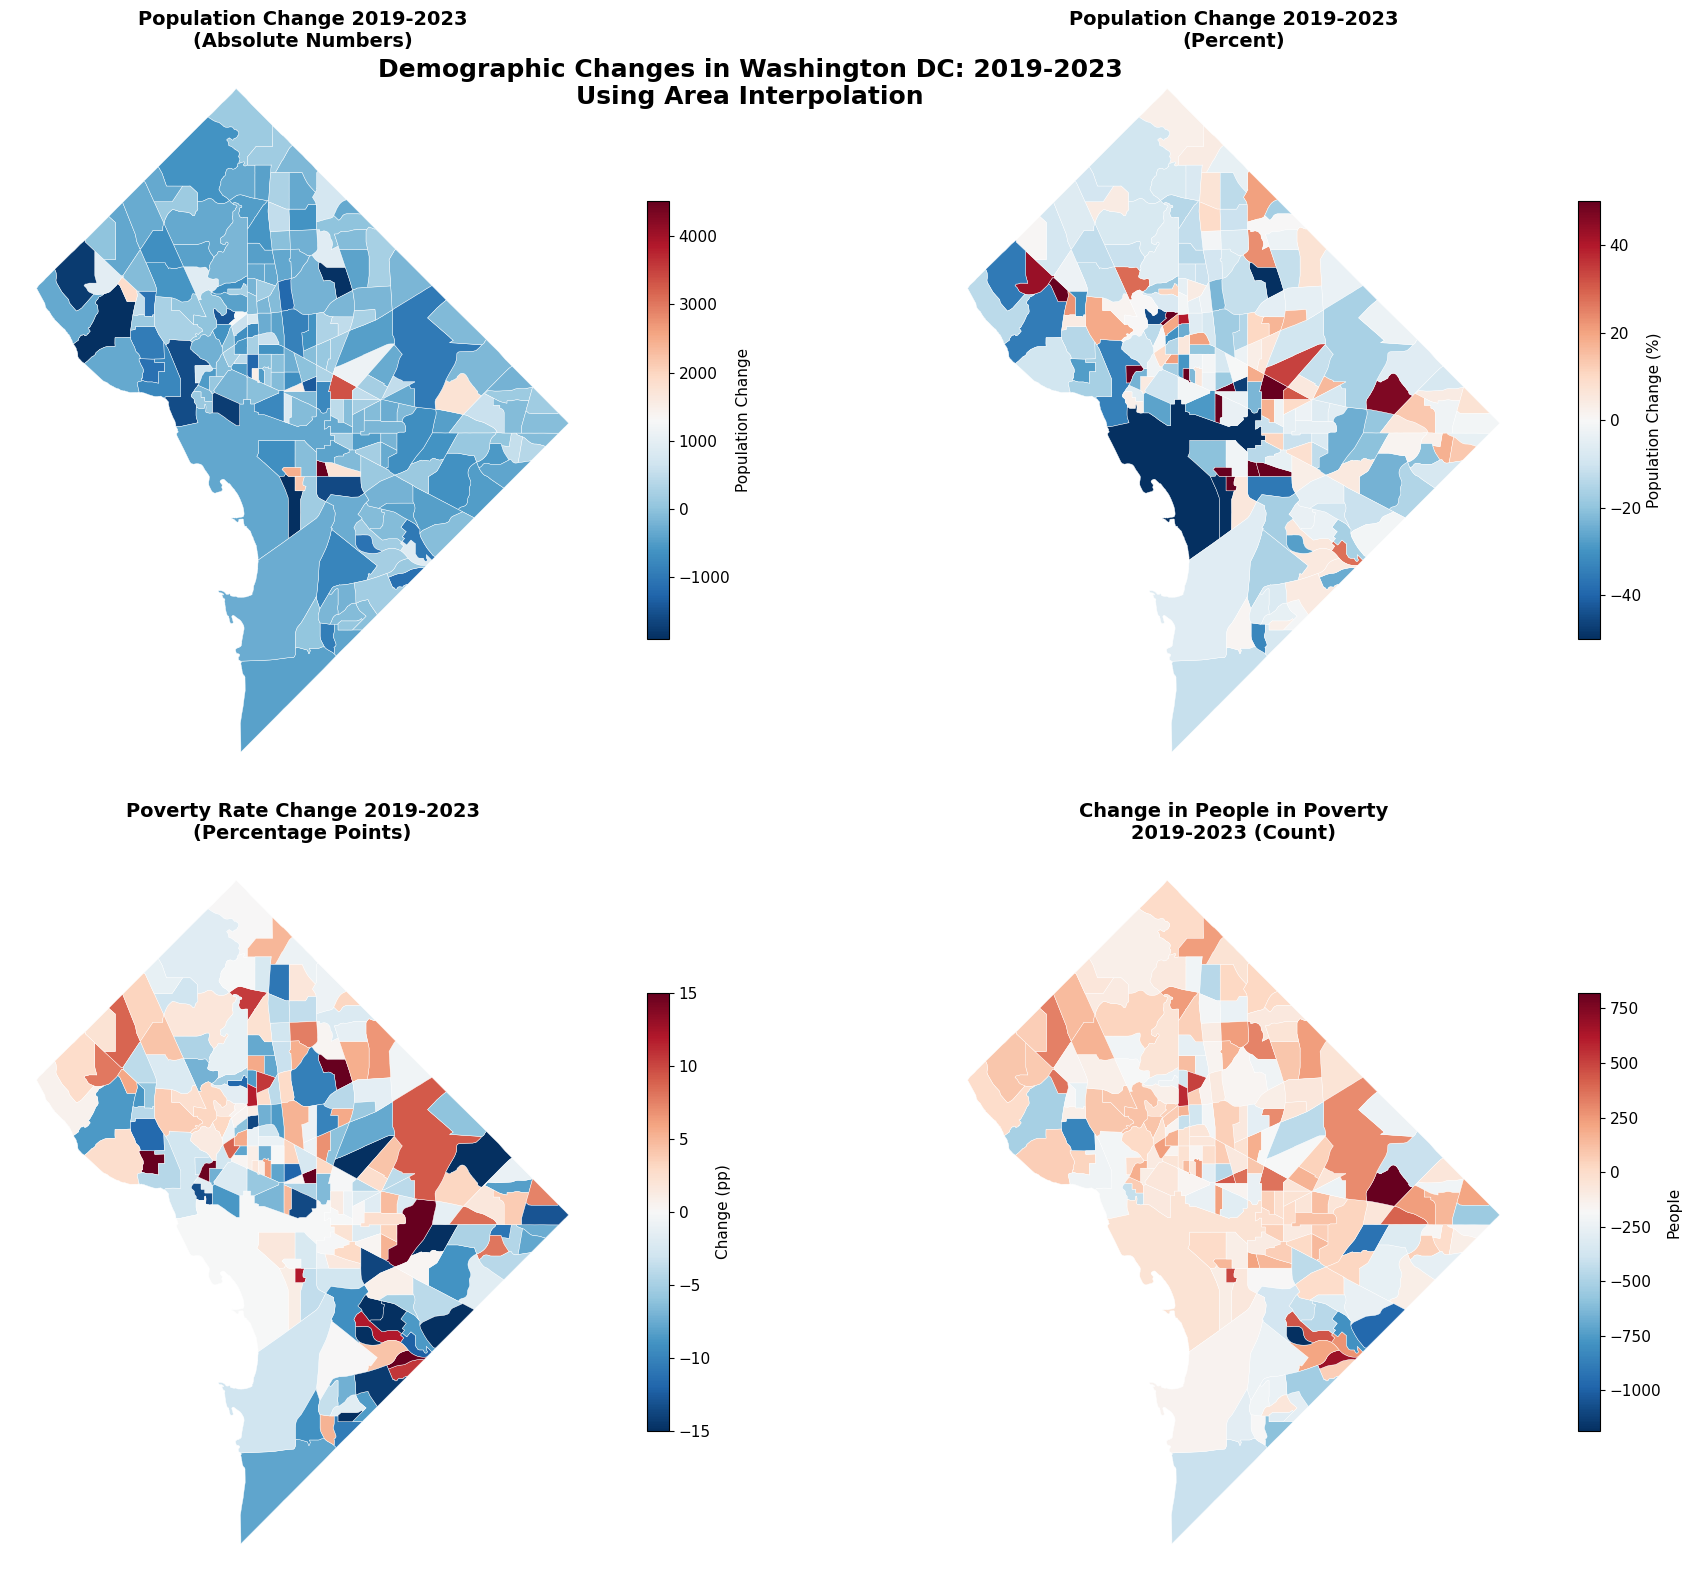

 VISUALIZATION BENEFITS:
 • All maps use identical tract boundaries (2023)
 • Direct comparison possible across all time periods
 • No manual coordinate system handling required
 • Automatic data validation ensures quality


In [11]:
# Create streamlined visualization using comparison results
if dc_comparison is not None:
 
 # All data already uses consistent 2023 boundaries!
 fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
 
 # Map 1: 2019 Population (Interpolated to 2023 boundaries)
 # dc_data uses multi-index columns like (2019, 'total_pop')
 dc_comparison.plot(
 column='total_pop_2019',
 cmap='Blues',
 legend=True,
 ax=ax1,
 edgecolor='white',
 linewidth=0.3,
 legend_kwds={'label': 'Population', 'shrink': 0.6}
 )
 ax1.set_title('2019 Total Population\n(Interpolated to 2023 Boundaries)', 
 fontsize=14, fontweight='bold')
 ax1.axis('off')
 
 # Map 2: 2023 Population
 dc_comparison.plot(
 column='total_pop_2023',
 cmap='Blues',
 legend=True,
 ax=ax2,
 edgecolor='white',
 linewidth=0.3,
 legend_kwds={'label': 'Population', 'shrink': 0.6}
 )
 ax2.set_title('2023 Total Population\n(2019-2023 ACS 5-year)', 
 fontsize=14, fontweight='bold')
 ax2.axis('off')
 
 # Map 3: Population Change (Absolute)
 dc_comparison.plot(
 column='total_pop_change',
 cmap='RdBu_r',
 legend=True,
 ax=ax3,
 edgecolor='white',
 linewidth=0.3,
 legend_kwds={'label': 'Population Change', 'shrink': 0.6}
 )
 ax3.set_title('Population Change 2019-2023\n(Absolute Numbers)', 
 fontsize=14, fontweight='bold')
 ax3.axis('off')
 
 # Map 4: Poverty Rate Change
 dc_comparison.plot(
 column='poverty_rate_change',
 cmap='RdBu_r',
 legend=True,
 ax=ax4,
 edgecolor='white',
 linewidth=0.3,
 vmin=-10,
 vmax=10,
 legend_kwds={'label': 'Change (pp)', 'shrink': 0.6}
 )
 ax4.set_title('Poverty Rate Change 2019-2023\n(Percentage Points)', 
 fontsize=14, fontweight='bold')
 ax4.axis('off')
 
 plt.tight_layout()
 plt.suptitle('Streamlined Time Series Analysis: DC Demographics\nAll Using Consistent 2023 Boundaries', 
 fontsize=18, fontweight='bold', y=0.96)
 plt.show()
 
 print(" VISUALIZATION BENEFITS:")
 print(" • All maps use identical tract boundaries (2023)")
 print(" • Direct comparison possible across all time periods")
 print(" • No manual coordinate system handling required")
 print(" • Automatic data validation ensures quality")
 
else:
 print("Cannot create visualization - missing comparison data")

In [23]:
dc_data.head()

year 2023 2019 \
variable GEOID total_pop poverty_count poverty_total total_pop 
0 11001000101 1181 37 1181 451.636066 
1 11001000102 3056 108 3056 4518.097078 
2 11001000201 2835 64 64 3924.464779 
3 11001000202 3964 465 3246 4731.010729 
4 11001000300 5669 372 5669 6635.270548 

year \
variable poverty_count poverty_total NAME state county 
0 32.325240 449.349611 District of Columbia, DC 11 001 
1 287.470956 4507.570324 District of Columbia, DC 11 001 
2 13.177578 74.464779 District of Columbia, DC 11 001 
3 702.394591 3716.973558 District of Columbia, DC 11 001 
4 1224.435672 6634.139383 District of Columbia, DC 11 001 

year \
variable tract geometry 
0 000101 POLYGON ((-77.04167 38.91153, -77.04135 38.911... 
1 000102 POLYGON ((-77.03195 38.91629, -77.03195 38.916... 
2 000201 POLYGON ((-77.00443 38.90252, -77.00415 38.903... 
3 000202 POLYGON ((-77.10517 38.91725, -77.10516 38.917... 
4 000300 POLYGON ((-77.0498 38.92788, -77.04967 38.9280... 

year poverty_rate_2019 poverty_rate_2023 2019 2023 
variable poverty_rate poverty_rate 
0 7.193784 3.132938 7.193784 3.132938 
1 6.377515 3.534031 6.377515 3.534031 
2 17.696390 100.000000 17.696390 100.000000 
3 18.896949 14.325323 18.896949 14.325323 
4 18.456586 6.562004 18.456586 6.562004

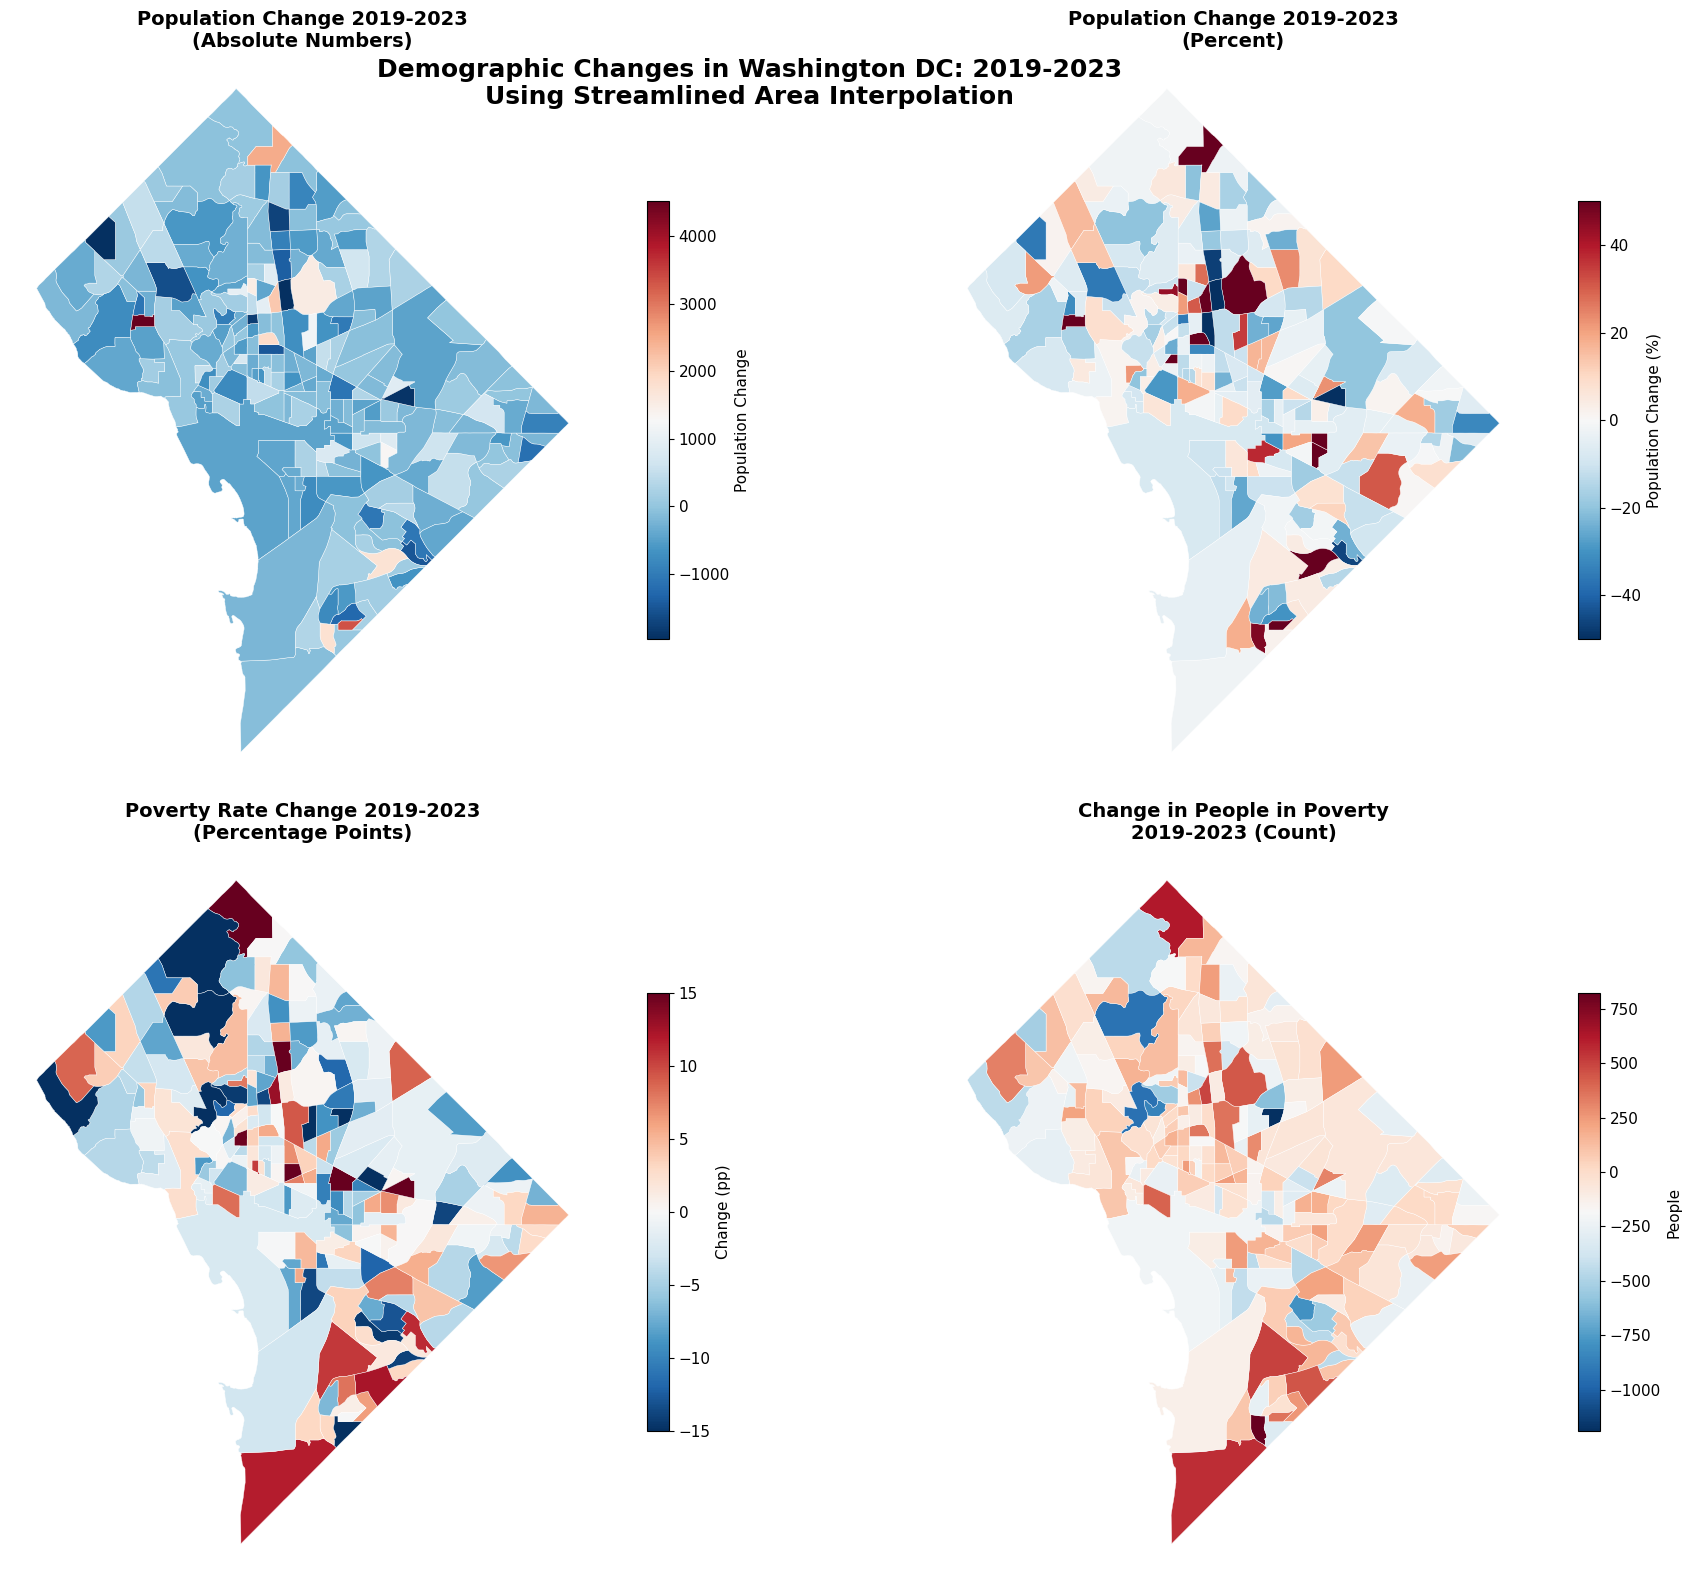


 INTERPRETING THE MAPS:
 • Blue areas: Decreases or lower values
 • Red areas: Increases or higher values
 • White areas: No data or minimal change
 • All maps use the same 2023 tract boundaries for direct comparison

 SPATIAL PATTERNS TO LOOK FOR:
 • Are population gains concentrated in specific neighborhoods?
 • How does poverty rate change relate to population change?
 • Are there clusters of improvement or decline?


In [24]:
# Create change-focused visualization
if dc_comparison is not None and not dc_comparison.empty:
 fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
 
 # Map 1: Population Change (Absolute)
 dc_comparison.plot(
 column='total_pop_change',
 cmap='RdBu_r',
 legend=True,
 ax=ax1,
 edgecolor='white',
 linewidth=0.3,
 legend_kwds={'label': 'Population Change', 'shrink': 0.6}
 )
 ax1.set_title('Population Change 2019-2023\n(Absolute Numbers)', 
 fontsize=14, fontweight='bold')
 ax1.axis('off')
 
 # Map 2: Population Change (Percent)
 # Handle infinite values
 pop_change_pct_clean = dc_comparison['total_pop_pct_change'].replace([np.inf, -np.inf], np.nan)
 dc_comparison_temp = dc_comparison.copy()
 dc_comparison_temp['pop_change_pct_clean'] = pop_change_pct_clean
 
 dc_comparison_temp.plot(
 column='pop_change_pct_clean',
 cmap='RdBu_r',
 legend=True,
 ax=ax2,
 edgecolor='white',
 linewidth=0.3,
 vmin=-50,
 vmax=50,
 legend_kwds={'label': 'Population Change (%)', 'shrink': 0.6}
 )
 ax2.set_title('Population Change 2019-2023\n(Percent)', 
 fontsize=14, fontweight='bold')
 ax2.axis('off')
 
 # Map 3: Poverty Rate Change
 dc_comparison.plot(
 column='poverty_rate_change',
 cmap='RdBu_r',
 legend=True,
 ax=ax3,
 edgecolor='white',
 linewidth=0.3,
 vmin=-15,
 vmax=15,
 legend_kwds={'label': 'Change (pp)', 'shrink': 0.6}
 )
 ax3.set_title('Poverty Rate Change 2019-2023\n(Percentage Points)', 
 fontsize=14, fontweight='bold')
 ax3.axis('off')
 
 # Map 4: Poverty Count Change
 dc_comparison.plot(
 column='poverty_count_change',
 cmap='RdBu_r',
 legend=True,
 ax=ax4,
 edgecolor='white',
 linewidth=0.3,
 legend_kwds={'label': 'People', 'shrink': 0.6}
 )
 ax4.set_title('Change in People in Poverty\n2019-2023 (Count)', 
 fontsize=14, fontweight='bold')
 ax4.axis('off')
 
 plt.tight_layout()
 plt.suptitle('Demographic Changes in Washington DC: 2019-2023\nUsing Streamlined Area Interpolation', 
 fontsize=18, fontweight='bold', y=0.96)
 plt.show()
 
 print("\n INTERPRETING THE MAPS:")
 print(" • Blue areas: Decreases or lower values")
 print(" • Red areas: Increases or higher values")
 print(" • White areas: No data or minimal change")
 print(" • All maps use the same 2023 tract boundaries for direct comparison")
 print()
 print(" SPATIAL PATTERNS TO LOOK FOR:")
 print(" • Are population gains concentrated in specific neighborhoods?")
 print(" • How does poverty rate change relate to population change?")
 print(" • Are there clusters of improvement or decline?")
 
else:
 print(" Cannot create change visualization - missing comparison data")
 print(" Make sure the comparison step completed successfully")

## Part 7: Statistical Analysis and Validation

Let's dig deeper into the patterns we observed and validate our interpolation results.

 DETAILED STATISTICAL ANALYSIS

POPULATION CHANGES:
   Mean change: -100 people
   Median change: -148 people
   Std deviation: 775
   Range: -1907 to +4512

POVERTY RATE CHANGES (percentage points):
   Mean: -0.70
   Median: -1.23
   Std deviation: 11.49
   Range: -26.4 to +85.0



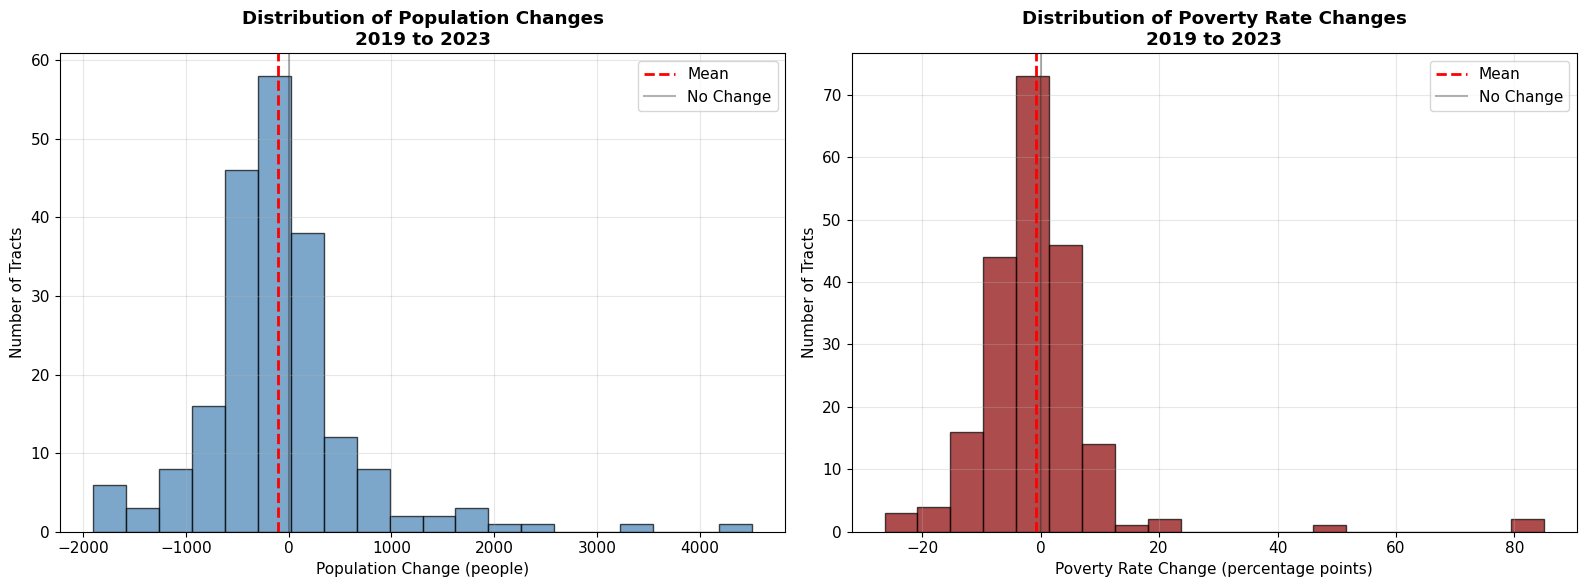


 INTERPRETATION TIPS:
 • Normal distributions suggest gradual, widespread changes
 • Outliers indicate tracts with exceptional changes
 • Scatter plot shows if population and poverty changes are related
 • Consider spatial autocorrelation - nearby tracts may show similar patterns


In [12]:
# Statistical analysis of changes
if dc_comparison is not None and not dc_comparison.empty:
 print(" DETAILED STATISTICAL ANALYSIS")
 print("=" * 60)
 print()
 
 # Population change distribution
 print(f"POPULATION CHANGES:")
 print(f" Mean change: {dc_comparison['total_pop_change'].mean():+,.0f} people")
 print(f" Median change: {dc_comparison['total_pop_change'].median():+,.0f} people")
 print(f" Std deviation: {dc_comparison['total_pop_change'].std():.0f}")
 print(f" Range: {dc_comparison['total_pop_change'].min():+,.0f} to {dc_comparison['total_pop_change'].max():+,.0f}")
 print()
 
 # Poverty rate change distribution
 print(f"POVERTY RATE CHANGES (percentage points):")
 print(f" Mean: {dc_comparison['poverty_rate_change'].mean():+.2f} pp")
 print(f" Median: {dc_comparison['poverty_rate_change'].median():+.2f} pp")
 print(f" Std deviation: {dc_comparison['poverty_rate_change'].std():.2f}")
 print(f" Range: {dc_comparison['poverty_rate_change'].min():+.1f} to {dc_comparison['poverty_rate_change'].max():+.1f}")
 print()
 
 # Poverty count change
 print(f"POVERTY COUNT CHANGES (people):")
 print(f" Total change: {dc_comparison['poverty_count_change'].sum():+,.0f} people")
 print(f" Mean change per tract: {dc_comparison['poverty_count_change'].mean():+,.0f} people")
 print(f" Tracts with fewer people in poverty: {(dc_comparison['poverty_count_change'] < 0).sum()}")
 print(f" Tracts with more people in poverty: {(dc_comparison['poverty_count_change'] > 0).sum()}")
 print()
 
 # Create histograms
 fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
 
 # Population change histogram
 ax1.hist(dc_comparison['total_pop_change'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
 ax1.axvline(dc_comparison['total_pop_change'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
 ax1.axvline(0, color='black', linestyle='-', alpha=0.3, label='No Change')
 ax1.set_xlabel('Population Change (people)')
 ax1.set_ylabel('Number of Tracts')
 ax1.set_title('Distribution of Population Changes\n2019 to 2023', fontweight='bold')
 ax1.legend()
 ax1.grid(True, alpha=0.3)
 
 # Poverty rate change histogram
 ax2.hist(dc_comparison['poverty_rate_change'], bins=30, alpha=0.7, color='darkred', edgecolor='black')
 ax2.axvline(dc_comparison['poverty_rate_change'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
 ax2.axvline(0, color='black', linestyle='-', alpha=0.3, label='No Change')
 ax2.set_xlabel('Poverty Rate Change (percentage points)')
 ax2.set_ylabel('Number of Tracts')
 ax2.set_title('Distribution of Poverty Rate Changes\n2019 to 2023', fontweight='bold')
 ax2.legend()
 ax2.grid(True, alpha=0.3)
 
 # Scatter plot: Population change vs Poverty rate change
 ax3.scatter(dc_comparison['total_pop_change'], dc_comparison['poverty_rate_change'], 
 alpha=0.5, color='purple', s=50)
 ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
 ax3.axvline(0, color='black', linestyle='-', alpha=0.3)
 ax3.set_xlabel('Population Change (people)')
 ax3.set_ylabel('Poverty Rate Change (percentage points)')
 ax3.set_title('Relationship: Population Change vs Poverty Rate Change', fontweight='bold')
 ax3.grid(True, alpha=0.3)
 
 # Poverty count change histogram
 ax4.hist(dc_comparison['poverty_count_change'], bins=30, alpha=0.7, color='darkgreen', edgecolor='black')
 ax4.axvline(dc_comparison['poverty_count_change'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
 ax4.axvline(0, color='black', linestyle='-', alpha=0.3, label='No Change')
 ax4.set_xlabel('Poverty Count Change (people)')
 ax4.set_ylabel('Number of Tracts')
 ax4.set_title('Distribution of Poverty Count Changes\n2019 to 2023', fontweight='bold')
 ax4.legend()
 ax4.grid(True, alpha=0.3)
 
 plt.tight_layout()
 plt.show()
 
 print("\n INTERPRETATION TIPS:")
 print(" • Normal distributions suggest gradual, widespread changes")
 print(" • Outliers indicate tracts with exceptional changes")
 print(" • Scatter plot shows if population and poverty changes are related")
 print(" • Consider spatial autocorrelation - nearby tracts may show similar patterns")
 
else:
 print(" Cannot perform statistical analysis - missing comparison data")

## Part 8: Best Practices and Limitations

### When to Use Area Interpolation

** Appropriate uses:**
- Comparing small geographies (tracts, block groups) across census years
- Geographic boundaries have changed between time periods
- You need comprehensive spatial coverage for analysis
- Data is reasonably evenly distributed within geographic areas
- Analyzing extensive variables (population counts, housing units)

** When NOT to use:**
- Analyzing point locations (schools, businesses, addresses)
- Data is highly concentrated in specific spots (e.g., high-rise buildings)
- Geography hasn't changed (use simple comparison instead)
- Very small sample sizes (ACS margins of error are too large)
- When you need exact precision (interpolation introduces uncertainty)

### Methodology Best Practices

**1. Coordinate Reference Systems**
- Always use projected CRS (e.g., EPSG:3857, State Plane) for area calculations
- Geographic CRS (lat/lon) produces distorted area calculations
- Choose appropriate CRS for your study area

**2. Variable Classification**
- **Extensive variables** (counts): Sum during interpolation
 - Examples: Total population, housing units, people in poverty
- **Intensive variables** (rates/ratios): Area-weighted average during interpolation
 - Examples: Median income, poverty rate, population density
- Incorrect classification leads to invalid results!

### Important Limitations

**Assumptions of Area Interpolation:**
1. **Uniform distribution**: Assumes data is evenly spread within source areas
 - Reality: Population clusters in specific areas
 - Impact: Can over/underestimate for areas with uneven distribution

2. **Area-based relationships**: Uses only geometric overlap, not actual patterns
 - Reality: People don't distribute based on land area alone
 - Impact: Less accurate for areas with varied land use

3. **Edge effects**: Boundaries create artificial breaks
 - Reality: Demographic patterns don't stop at boundaries
 - Impact: Small errors accumulate, especially for small areas

4. **Intensive variable averaging**: Weighted by area, not population
 - Reality: Income varies by population density, not just area
 - Impact: Better to calculate rates from interpolated counts when possible

**Data Quality Considerations:**
- ACS margins of error increase with area interpolation
- Small geographic areas have inherently larger uncertainty
- 5-year ACS data already represents averaged values
- Differential privacy in 2020+ Census adds noise to small counts


## IMPORTANT: Understanding ACS Time Periods

### Why This Tutorial Uses 2019 and 2023

This tutorial compares **2019 ACS5 (2015-2019)** with **2023 ACS5 (2019-2023)**. While these periods share one overlapping year (2019), they are used here primarily to demonstrate the technical methodology of boundary interpolation.

 
### Additional Resources

#### What Are Overlapping Periods?

For ACS 5-year estimates, each year represents 5 years of data:
- **2019 ACS5** = 2015, 2016, 2017, 2018, 2019 data
- **2020 ACS5** = 2016, 2017, 2018, 2019, 2020 data (4 years overlap!)
- **2023 ACS5** = 2019, 2020, 2021, 2022, 2023 data (1 year overlap with 2019)

#### Why Overlapping Periods Are Problematic

When ACS periods overlap, they share common years of data, creating **statistical dependence** between the estimates. This violates the independence assumption required for:
- Hypothesis testing (t-tests, significance tests)
- Confidence intervals for change
- Statistical trend analysis
- Regression analysis

#### pytidycensus Will Warn You

When you use `get_time_series()` with overlapping periods, pytidycensus automatically displays a comprehensive warning explaining:
- Which periods overlap
- Why this matters statistically
- What you should do instead

#### Best Practices for Valid Time Series Analysis

**For Statistical Comparisons (Recommended):**
1. Use **non-overlapping years** with 5+ year gaps for ACS5:
   - Good: 2012, 2017, 2022 (no overlap)
   - Good: 2015, 2020, 2025 (no overlap)
   - Bad: 2018, 2019, 2020 (massive overlap)

2. Use **ACS 1-year estimates** if available for your geography:
   - Available for geographies with 65,000+ population
   - Each year is independent (no overlap)
   - More appropriate for annual trend analysis

3. Use **Decennial Census** for 10-year comparisons:
   - 2010 vs 2020 (completely independent)
   - Complete population count (not a sample)

**For Descriptive Purposes Only:**
- Overlapping periods can show general patterns
- Use for visualization and exploration
- Do NOT perform statistical tests
- Do NOT calculate confidence intervals for change
- Be explicit that comparisons are descriptive only

#### More Information

- [Census Bureau: Comparing ACS Data](https://www.census.gov/programs-surveys/acs/guidance/comparing-acs-data.html)
- [When to Use 1-year, 3-year, or 5-year Estimates](https://www.census.gov/programs-surveys/acs/guidance/estimates.html)

**In this tutorial:** We use 2019 vs 2023 primarily to demonstrate the technical methods. For real research with statistical inference, use non-overlapping periods!